# Assigning probabilities

Last revised: 30-Sep-2019 by Christian Forssén [christian.forssen@chalmers.se]

## Python/Jupyter set up

In [1]:
%matplotlib inline   

In [2]:
import numpy as np

import scipy.stats as stats
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context("talk")


## Prior pdfs for straight line model

In [3]:
# Modules needed for Example 1
import emcee

We will define three different priors for the straight line model. Using always a flat prior U(-100,100) for the intercept, and a non-zero pdf range -100 <= slope <= 100.

In [4]:
def log_flat_prior(theta):
    if np.all(np.abs(theta) < 100):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_jeffreys_prior(theta):
    if np.abs(theta[0]) < 100:
        return -0.5 * np.log(theta[1] ** 2)
    else:
        return -np.inf  # log(0)    
    
def log_symmetric_prior(theta):
    if np.abs(theta[0]) < 100:
        return -1.5 * np.log(1 + theta[1] ** 2)
    else:
        return -np.inf  # log(0)

Let us create 1000 samples from each prior pdf and plot the resulting sample of straight lines.
Since the intercept is uniformly distributed in all three prior alternatives, we will just consider straight lines with intercept 0 since it makes it easier to compare the distribution of slopes.

In [5]:
def log_prior(th1,logp):
    return logp([0,th1])

In [6]:
ndim = 1  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take
ncorr = 100 # just keep every ncorr sample

# we'll start at random locations within the prior volume
np.random.seed(2019)
starting_guesses = 100 * np.random.rand(nwalkers,ndim)

MCMC sampling of log_flat_prior using emcee with 10 walkers


/var/folders/_s/v5m4jp4x2y332nzvt9zn1qxr0000gn/T/ipykernel_10409/4029062767.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.all(np.abs(theta) < 100):


Mean acceptance fraction: 0.828 (in total 100000 steps)
MCMC sampling of log_jeffreys_prior using emcee with 10 walkers


ValueError: too many values to unpack (expected 3)

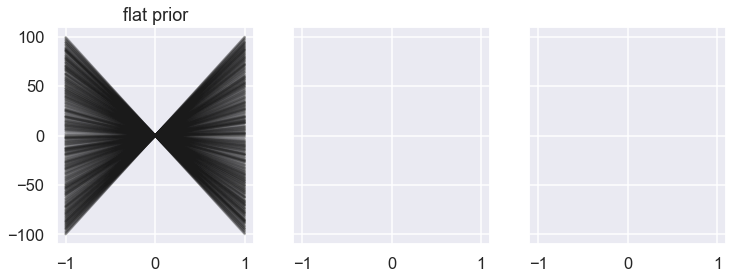

In [7]:
x = [-1,1]
fig,axs = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)

for ipr,logpr in enumerate([log_flat_prior,log_jeffreys_prior,log_symmetric_prior]):
    np.random.seed(2019)
    strprior = str(logpr).split()[1]
    print(f"MCMC sampling of {strprior} using emcee with {nwalkers} walkers")
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prior, args=[logpr])

    # "burn-in" period; save final positions and then reset
    pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
    sampler.reset()

    # sampling period
    sampler.run_mcmc(pos, nsteps)

    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                    .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

    # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
    samples = sampler.chain.reshape((-1, ndim))

    # just keep every ncorr sample
    samples_sparse = samples[::ncorr]
    
    for sample in samples_sparse:
        axs[ipr].plot(x,x*sample,'k',alpha=0.1)
        axs[ipr].set_title(strprior.split('_')[1]+' prior')
    
axs[0].set_xlim([0,1]);
axs[0].set_ylim([0,1]);
axs[0].set_xlabel(r'$x$');
axs[0].set_ylabel(r'$y=\theta x$');
#fig.savefig('slope_priors.png')

## Entropy for Scandinavians

Consider the following table with probabilities for different traits of Scandinavians. It is based on the knowledge that 70% of Scandinavians are blonde and that 10% are left handed. It should be admitted that these numbers are guesses since no reliable data was found, but it will be considered a fact for this study.

|  | Left-handed    | Right-handed |
|--|----------------|--------------|
| Blonde | $0\le x \le 0.1$    | $0.7 - x$ |
| Not blonde | $0.1 - x$ | $0.2 + x$ |

**Question:**
Can you explain why $x \lt 0.07$ implies a negative correlation between left-handedness and blonde hair, while $x \gt 0.07$ implies a positive correlation?

In [ ]:
# Insert your answer here
#

In [ ]:
def pdf_Scandinavian(x):
    '''Returns the pdf (p1,p2,p3,p4)'''
    return np.array([x,0.7-x,0.1-x,0.2+x])

In [ ]:
x=np.linspace(0.001,0.0999,1000)
pdf = pdf_Scandinavian(x)
fun0=-np.sum(pdf*np.log(pdf),axis=0)
x0 = x[np.argmax(fun0)]
print(f"-sum p log(p):    x={x0:.3f}")
fun1=np.sum(np.sqrt(pdf*(1.-pdf)),axis=0)
x1 = x[np.argmax(fun1)]
print(f"sum sqrt(p(1-p)): x={x1:.3f}")
fun2=np.sum(np.log(pdf),axis=0)
x2 = x[np.argmax(fun2)]
print(f"sum log(p):       x={x2:.3f}")
fun3=-np.sum(pdf**2*np.log(pdf),axis=0)
x3 = x[np.argmax(fun3)]
print(f"-sum p**2*log(p):  x={x3:.3f}")

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(x,fun0/np.abs(np.max(fun0)),'k-',label=r'$-p \log(p)$')
ax.plot(x0,1,'ko')
ax.plot(x,0.9*fun1/np.abs(np.max(fun1)),'b--',label=r'$\sqrt{p(1-p)}$')
ax.plot(x1,.9,'bo')
ax.plot(x,0.8*(2+fun2/np.abs(np.max(fun2))),'g-.',label=r'$\log(p)$')
ax.plot(x2,0.8,'go')
ax.plot(x,0.7*fun3/np.abs(np.max(fun3)),'r:',label=r'$-p^2 \log(p)$')
ax.plot(x3,0.7,'ro')
ax.axvline(0.07)
ax.set_xlabel(r'$x$')
ax.set_ylabel('variational function')
ax.legend(loc='best');

## The six-sided die with known mean